<div align="center">

# Lista 5

</div>

<div align="center" style="">

### Importy

</div>

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import numpy as np

<div align="center" style="">

### Wczytanie danych oraz przerobienie ich

</div>

In [33]:
df = pd.read_csv('Titanic Dataset.csv')

df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked']]

df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['fare'] = df['fare'].fillna(df['fare'].median())

label_encoders = {}

for col in ['sex', 'embarked']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['survived'])
y = df['survived']

<div align="center" style="">

### Podzielenie danych na testowe i treningowe

</div>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

<div align="center" style="">

### Funkcje służące zmienające zmienne numeryczne na kategoryczne

</div>

In [35]:
from sklearn.cluster import KMeans

def fit_equal_width(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_width(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_equal_freq(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        try:
            _, edges = pd.qcut(X_train[col], q=k, retbins=True, duplicates='drop')
        except ValueError:
            # za mało unikalnych wartości - fallback do cut
            _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_freq(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_kmeans(X_train, k):
    models = {}
    for col in ['age','sibsp','parch','fare']:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X_train[[col]])
        models[col] = km
    return models

def transform_kmeans(X, models):
    Xq = X.copy()
    for col, km in models.items():
        Xq[col] = km.predict(X[[col]])
    return Xq


<div align="center" style="">

### Ewaluacja

</div>

In [36]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

def evaluate(method, k):
    fit_obj = method['fit'](X_train, k)
    X_train_q = method['transform'](X_train, fit_obj)
    X_test_q  = method['transform'](X_test, fit_obj)

    model = CategoricalNB()
    model.fit(X_train_q, y_train)
    y_pred = model.predict(X_test_q)

    return accuracy_score(y_test, y_pred)


dsdsa

In [37]:
methods = {
    "equal_width": {
        "fit": fit_equal_width,
        "transform": transform_equal_width
    },
    "equal_freq": {
        "fit": fit_equal_freq,
        "transform": transform_equal_freq
    },
    "kmeans": {
        "fit": fit_kmeans,
        "transform": transform_kmeans
    }
}

results = []

print(methods.items())

for method_name, method_funcs in methods.items():
    for k in [2, 5, 10, 25]:
        acc = evaluate(method_funcs, k)
        results.append([method_name, k, acc])

import pandas as pd
results_df = pd.DataFrame(results, columns=["method", "k", "accuracy"])
print(results_df)


dict_items([('equal_width', {'fit': <function fit_equal_width at 0x000001AD54418A40>, 'transform': <function transform_equal_width at 0x000001AD544189A0>}), ('equal_freq', {'fit': <function fit_equal_freq at 0x000001AD544A9940>, 'transform': <function transform_equal_freq at 0x000001AD544A9BC0>}), ('kmeans', {'fit': <function fit_kmeans at 0x000001AD544AA160>, 'transform': <function transform_kmeans at 0x000001AD544AA0C0>})])
         method   k  accuracy
0   equal_width   2  0.729008
1   equal_width   5  0.729008
2   equal_width  10  0.740458
3   equal_width  25  0.706107
4    equal_freq   2  0.717557
5    equal_freq   5  0.717557
6    equal_freq  10  0.732824
7    equal_freq  25  0.721374
8        kmeans   2  0.717557
9        kmeans   5  0.736641
10       kmeans  10  0.725191
11       kmeans  25  0.725191


c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct 

<div align="center">

## Zadanie 2

</div>

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def analyze_dataset(path):
    # Wczytaj macierz n x 2
    X = np.load(path)   # np.array o wymiarze (n, 2)

    # ---------- KMeans ----------
    kmeans = KMeans(n_clusters=3, random_state=0)
    labels_km = kmeans.fit_predict(X)

    # ---------- GMM ----------
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    labels_gmm = gmm.fit_predict(X)

    # ---------- Wizualizacja ----------
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(X[:,0], X[:,1], c=labels_km, s=20)
    axs[0].set_title("K-Means clustering")

    axs[1].scatter(X[:,0], X[:,1], c=labels_gmm, s=20)
    axs[1].set_title("Gaussian Mixture Model")

    plt.suptitle(path)
    plt.show()

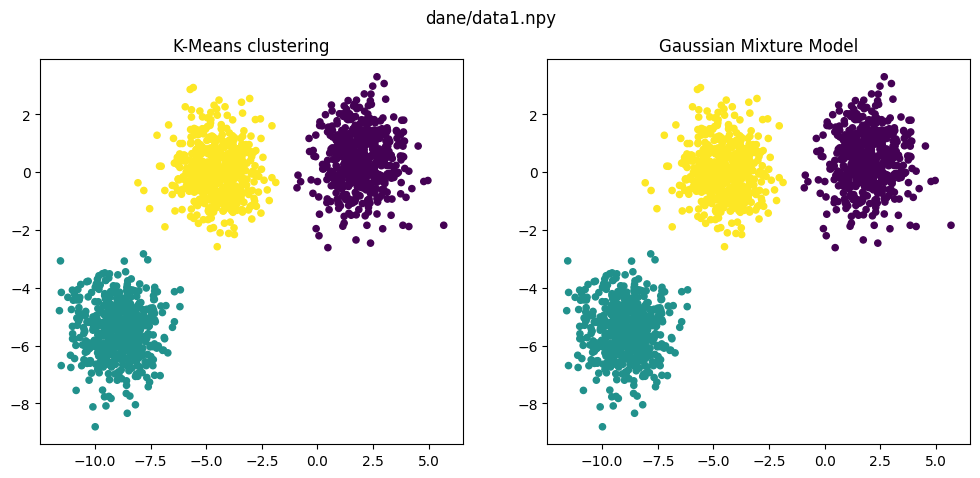

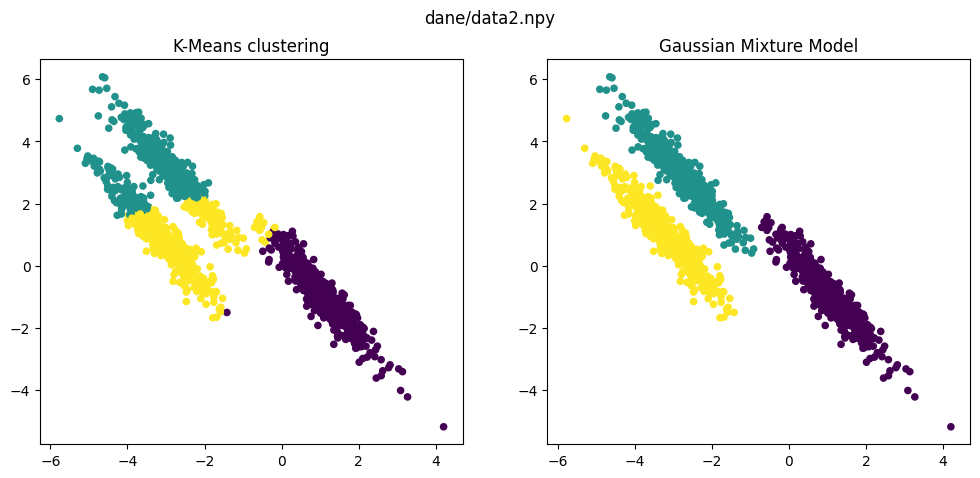

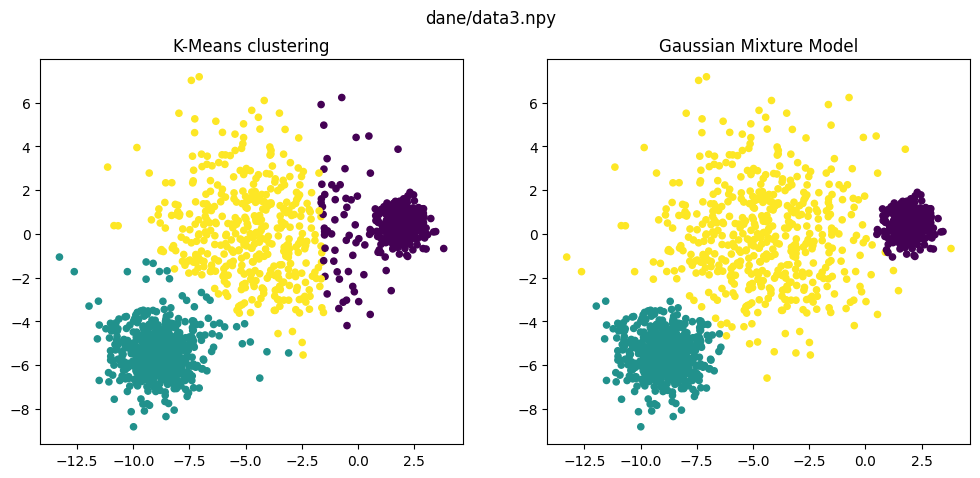

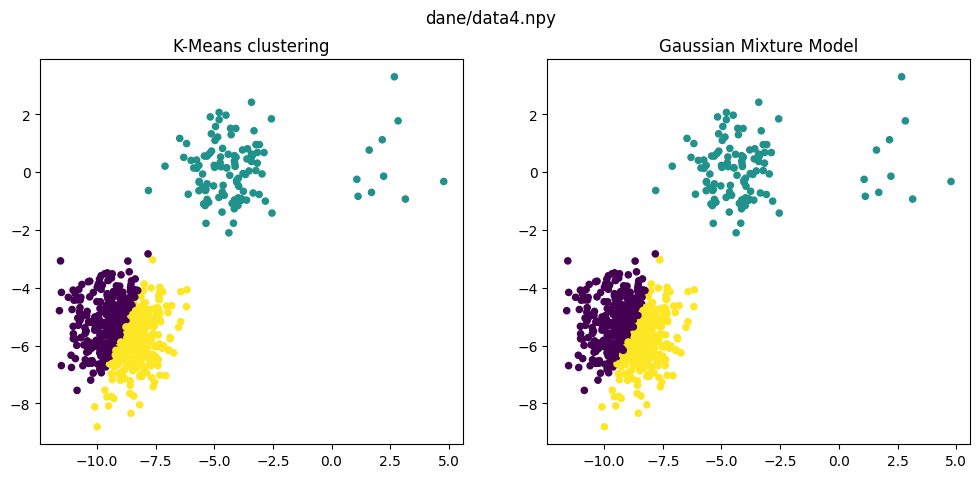

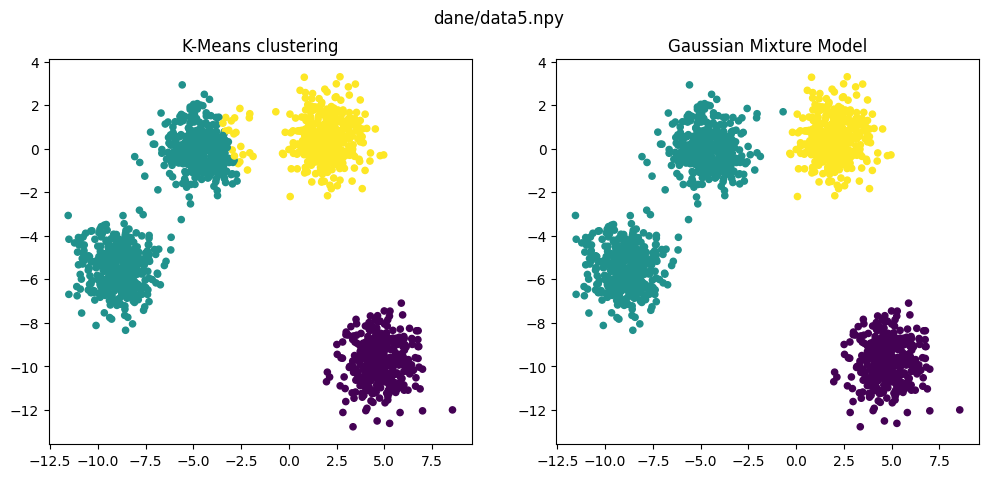

In [39]:
for i in range(1, 6):
    analyze_dataset(f"dane/data{i}.npy")


<div align="center">

## Zadanie 3

</div>

In [40]:
import numpy as np

images = np.load('dane/image_emb.npy')
images_lable = np.load('dane/image_labels.npy', allow_pickle=True)
images_test = np.load('dane/image_emb_test.npy')
images_labels_test = np.load('dane/image_labels_test.npy', allow_pickle=True)


labled_idx = np.where(images_lable != '')
mask = images_lable != ''
classes = np.unique(images_lable[images_lable != ''])


print(classes)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


# Tworzenie modelu

In [41]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from collections import Counter

kmeans = KMeans(n_clusters=len(classes), random_state=69)
clussters = kmeans.fit_predict(X=images)

def get_clusster_to_class(c, il):
    clusster_to_class = [Counter() for _ in range(len(classes))]

    for num, cls in zip(c, il):
        clusster_to_class[num][cls] += 1

    print(clusster_to_class)

    return {i: clusster_to_class[i].most_common()[0][0] for i in range(len(clusster_to_class))}


hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

res = [hash_map[c] for c in clussters]

test_clusters = kmeans.predict(X=images_test)
test_pred = [hash_map[c] for c in test_clusters]


acc = accuracy_score(images_labels_test, test_pred)

print("(K-MEANS) Accuracy:", acc)

# gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=69)
# clussters = gmm.fit_predict(X=images)

# hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

# res = [hash_map[c] for c in clussters]

# test_clusters = gmm.predict(X=images_test)
# test_pred = [hash_map[c] for c in test_clusters]


# acc = accuracy_score(images_labels_test, test_pred)

# print("(GMM) Accuracy:", acc)

[Counter({'airplane': 3, 'ship': 2, 'automobile': 1}), Counter({'deer': 5, 'cat': 1}), Counter({'ship': 3}), Counter({'airplane': 2}), Counter({'frog': 5}), Counter({'automobile': 4}), Counter({'horse': 5}), Counter({'dog': 5, 'cat': 4, 'bird': 1}), Counter({'truck': 5}), Counter({'bird': 4})]
(K-MEANS) Accuracy: 0.7513333333333333


<div align="center">

## Zadanie 4

</div>

In [42]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('pca', KernelPCA(n_components=100, random_state=42, kernel='rbf'))
])

pca_matrix = pipeline.fit_transform(newsgroups.data)
print("Shape:", pca_matrix.shape)

Shape: (11314, 100)


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

scores = []
K = range(2, 21)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(pca_matrix)
    scores.append(silhouette_score(pca_matrix, labels))

for k, s in zip(K, scores):
    print(k, s)

2 0.16012745788148958
3 0.11323969899931194
4 0.11299401511120859
5 0.11462332158525622
6 0.016369156652843535
7 0.0211339840477161
8 0.012365126322932424
9 0.030132274152777604
10 0.037433239810792544
11 0.021512309788226103
12 0.03135082790544716
13 0.03409562239071512
14 0.029995512435541594
15 0.03458865445461139
16 0.04027006160265408
17 0.043048276559046576
18 0.04066234996674351
19 0.0439826964387853
20 0.0461868546183585


In [45]:
inertias = []

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(pca_matrix)
    inertias.append(model.inertia_)

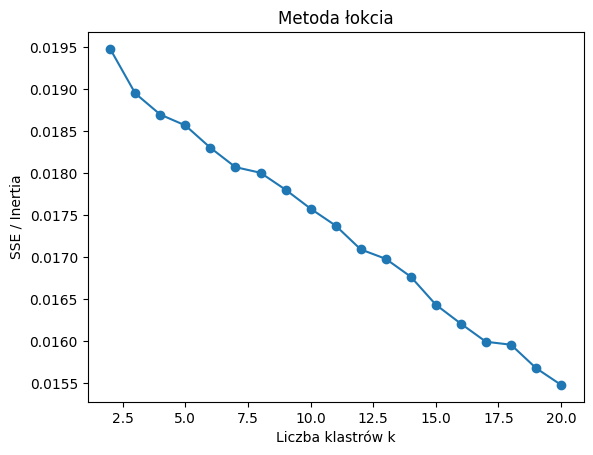

In [46]:
import matplotlib.pyplot as plt

plt.plot(K, inertias, 'o-')
plt.xlabel("Liczba klastrów k")
plt.ylabel("SSE / Inertia")
plt.title("Metoda łokcia")
plt.show()

In [47]:
k = 5
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(pca_matrix)

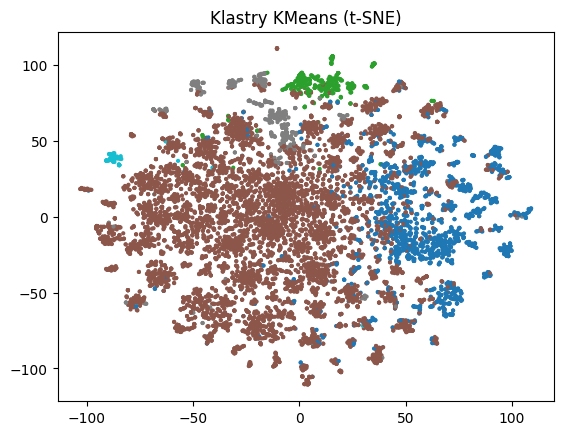

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
matrix_2d = tsne.fit_transform(pca_matrix)

plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=cluster_labels, cmap='tab10', s=4)
plt.title("Klastry KMeans (t-SNE)")
plt.show()


In [49]:
import numpy as np

for i in range(k):
    print(f"\n=== Klaster {i} ===")
    idx = np.where(cluster_labels == i)[0][:5]  # 5 przykładowych tekstów
    for j in idx:
        print(newsgroups.data[j][:200].replace("\n", " "), "...")


=== Klaster 0 ===
From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas) Subject: Re: Rewording the Second Amendment (ideas) Organization: VTT Lines: 58  In article <1r1eu1$4t@transfer.stratus.com> cdt@sw.stratus.com (C. D. Tav ...
From: david@terminus.ericsson.se (David Bold) Subject: Re: Question for those with popular morality Reply-To: david@terminus.ericsson.se Distribution: world Organization: Camtec Electronics (Ericsson) ...
From: mathew <mathew@mantis.co.uk> Subject: Re: <Political Atheists? Organization: Mantis Consultants, Cambridge. UK. X-Newsreader: rusnews v1.01 Lines: 22  kmr4@po.CWRU.edu (Keith M. Ryan) writes: >  ...
From: keith@cco.caltech.edu (Keith Allan Schneider) Subject: Re: <<Pompous ass Organization: California Institute of Technology, Pasadena Lines: 16 NNTP-Posting-Host: punisher.caltech.edu  livesey@sol ...
From: jonh@david.wheaton.edu (Jonathan Hayward) Subject: Re: Pantheism & Environmentalism Organization: Wheaton College, IL Lines: 46  In article <Apr.5.23.31.36

<div align="center">

## Zadanie 5

</div>

In [50]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups()

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

# Create a pipeline with TfidfVectorizer and PCA
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('pca', KernelPCA(n_components=100, random_state=42))
])

# Fit and transform the data using the pipeline
pca_matrix = pipeline.fit_transform(newsgroups_train.data)

# Display the shape of the resulting matrix
print("Shape of PCA matrix:", pca_matrix.shape)

Shape of PCA matrix: (11314, 100)


Trenowanie zakończyło się po 37 iteracjach


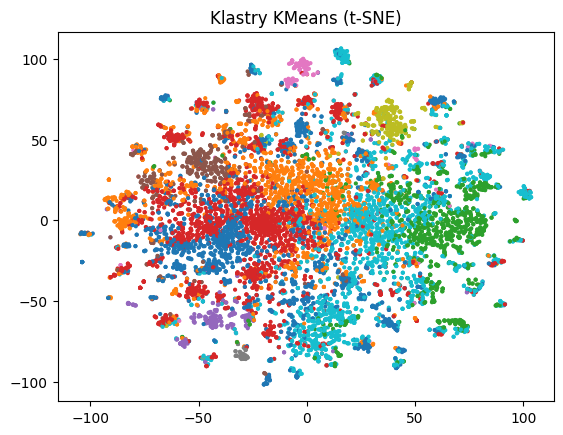

In [52]:
import numpy as np

class KMeans:
    def __init__(self, n_clusters, random_state):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.clusters = {}
        self.trained = False

    def _init_clusters(self, X):
        np.random.seed(self.random_state)

        self.trained = True
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        
        for i, choosen_idx in enumerate(idx):
            self.clusters[i] = {
                'center': X[choosen_idx].copy(),
                'points': [],
            }

    def _distance(self, x1, x2):
        return np.linalg.norm(x1 - x2)
    
    def _assign_clusters(self, X):
        for x in X:
            dist = np.array([self._distance(self.clusters[i]['center'], x ) for i in self.clusters])
            self.clusters[np.argmin(dist)]['points'].append(x) # Do najlepszego klastra dopisujemy punkt

    def _update_clusters(self):
        for i in self.clusters:
            pts = np.array(self.clusters[i]['points'])
            if pts.shape[0] > 0:
                self.clusters[i]['center'] = pts.mean(axis=0)

    def _clear_cluster_points(self):
        for i in self.clusters:
            self.clusters[i]['points'] = []

    def _clusters_equal(self, centroids):
        for i in self.clusters:
            if (centroids[i] != self.clusters[i]['center']).any():
                return False
        return True

    def fit(self, X):
        # Zaincjalizuj klastry
        self._init_clusters(X)

        for iter in range(100):
            last_centroids = [self.clusters[i]['center'].copy() for i in self.clusters]
            self._assign_clusters(X)
            self._update_clusters()
            self._clear_cluster_points()
            if (self._clusters_equal(last_centroids)):
                break

        print(f'Trenowanie zakończyło się po {iter} iteracjach')

    def partial_fit(self, X, lr=0.1):
        """
        Online update of centroids using incremental K-Means (MacQueen method).
        X - new batch of points
        lr - learning rate (0.05 - 0.2 is typical)
        """

        # jeśli fit() nie było wywołane
        if not self.trained:
            raise ValueError("Musisz najpierw wywołać fit() żeby zainicjalizować centroidy")

        for x in X:
            # znajdujemy najbliższy centroid
            distances = [
                self._distance(x, self.clusters[i]['center'])
                for i in range(self.n_clusters)
            ]
            best = np.argmin(distances)

            # aktualizacja centroidu - online gradient step
            old_center = self.clusters[best]['center']
            new_center = old_center + lr * (x - old_center)

            self.clusters[best]['center'] = new_center
       
    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self._distance(x, self.clusters[i]['center']) for i in range(self.n_clusters)]
            best_cluster = np.argmin(distances)
            predictions.append(best_cluster)
        return predictions

kmeans = KMeans(n_clusters=10, random_state=16)
kmeans.fit(pca_matrix)
labels = kmeans.predict(pca_matrix)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
matrix_2d = tsne.fit_transform(pca_matrix)

plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=labels, cmap='tab10', s=4)
plt.title("Klastry KMeans (t-SNE)")
plt.show()

Trenowanie zakończyło się po 33 iteracjach


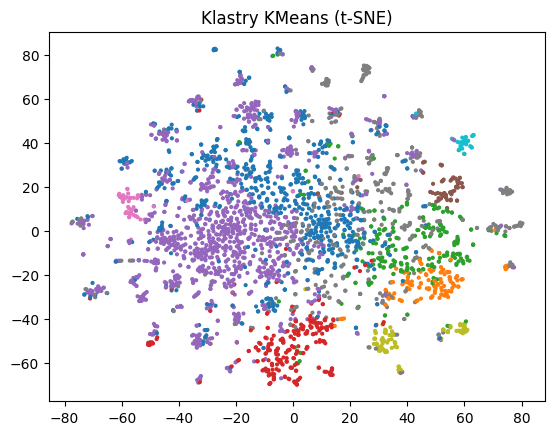

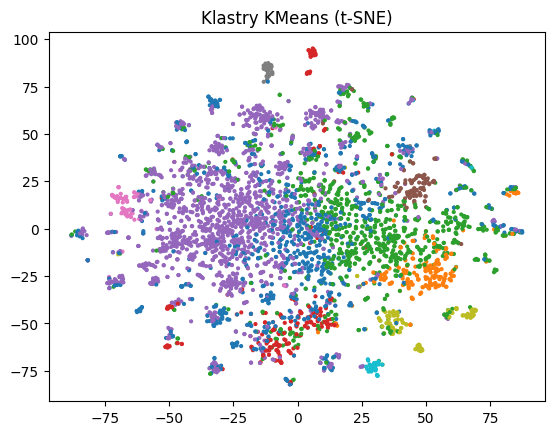

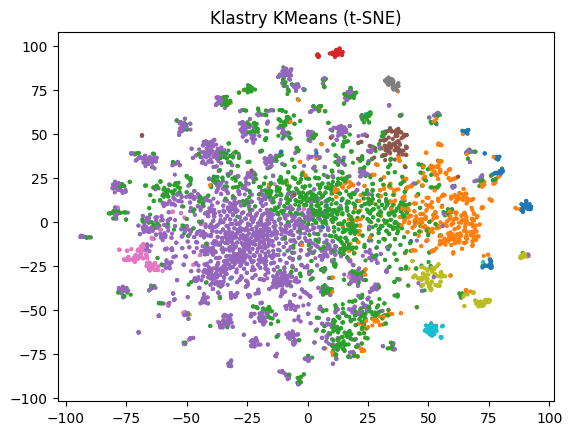

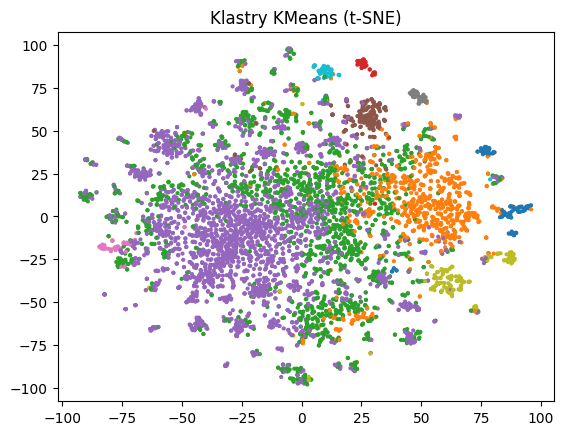

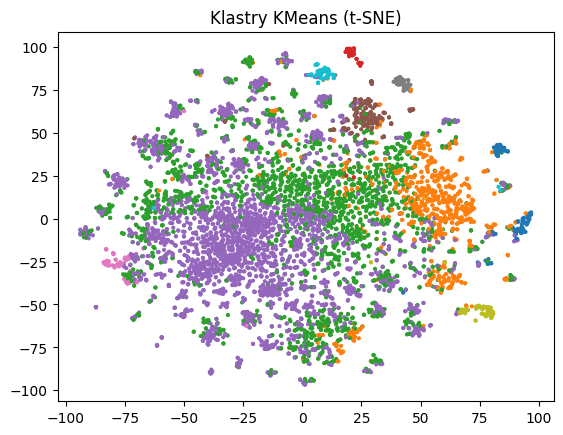

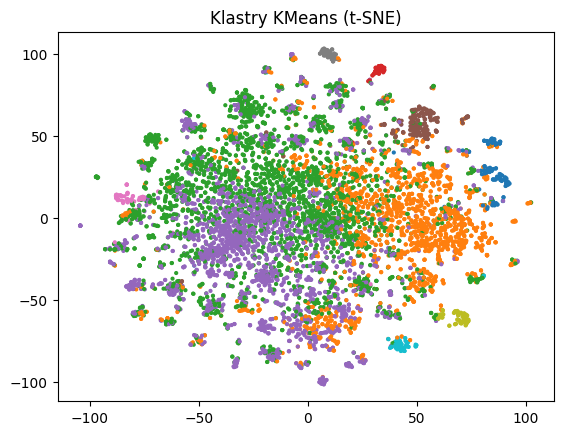

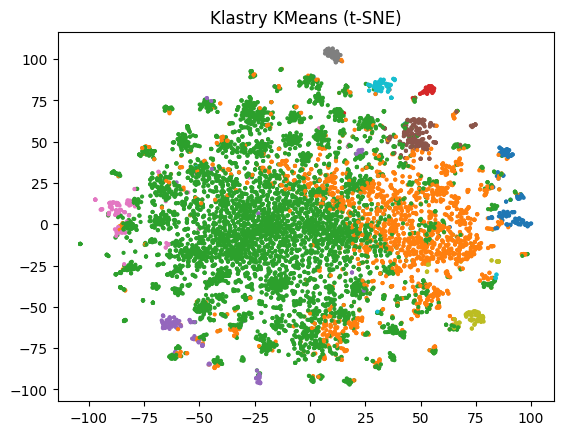

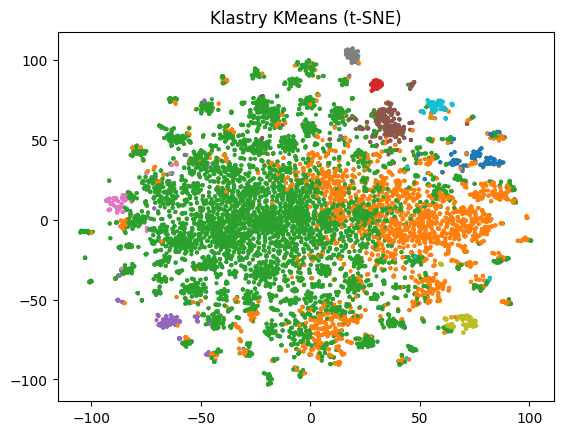

In [53]:
from sklearn.model_selection import train_test_split

X_pretrain, X_online = train_test_split(
    pca_matrix,
    test_size=0.7,
    random_state=42,
    shuffle=True
)

online_parts = np.array_split(X_online, 7)

kmeans = KMeans(n_clusters=10, random_state=16)
kmeans.fit(X_pretrain)
labels = kmeans.predict(X_pretrain)

tsne = TSNE(n_components=2, random_state=16, perplexity=15)
matrix_2d = tsne.fit_transform(X_pretrain)

plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=labels, cmap='tab10', s=4)
plt.title("Klastry KMeans (t-SNE)")
plt.show()


for i in range(len(online_parts)):
    kmeans.partial_fit(online_parts[i])
    labels = kmeans.predict(np.concatenate([X_pretrain] + online_parts[:i+1]))

    tsne = TSNE(n_components=2, random_state=16, perplexity=15)
    matrix_2d = tsne.fit_transform(np.concatenate([X_pretrain] + online_parts[:i+1]))

    plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=labels, cmap='tab10', s=4)
    plt.title("Klastry KMeans (t-SNE)")
    plt.show()
